# Calibrate distance Source-Detector at VULCAN

We will be using Al Bragg edge peaks for this on the Open Beam (OB) data

In [1]:
from PIL import Image
import numpy as np

In [2]:
from pprint import pprint
from ipywidgets import widgets
from ipywidgets.widgets import interact
from IPython.display import display

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [4]:
import glob

In [5]:
#%matplotlib notebook
%matplotlib inline

In [6]:
import pyfits

In [7]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Setup plot.ly 

In [8]:
from plotly.offline  import plot
from plotly.graph_objs import *
import plotly.tools as lts
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py

In [9]:
py.sign_in('jeanbilheux', 'pnvcy0lryl')

In [10]:
init_notebook_mode()

## Load OB data

**USER** =====>  which OB folder to use

In [38]:
# root dir
root_dir = '/Volumes/My Book Thunderbolt Duo/IPTS/BraggEdge/VULCAN/Runs#39_3600sec_#40_601sec_Open_Beam/'

In [40]:
# OBs
data_dir = root_dir + 'data_image040'
print(data_dir)

/Volumes/My Book Thunderbolt Duo/IPTS/BraggEdge/VULCAN/Runs#39_3600sec_#40_601sec_Open_Beam/data_image040


In [41]:
list_fname = glob.glob(data_dir + '/*')

In [42]:
pprint("Number of files to load: %d" %(len(list_fname)))

'Number of files to load: 1490'


Make sure files are sorted the right way !

In [43]:
#pprint(list_fname)

Load images

In [44]:
nbr_data = len(list_fname)
OBs = []

w = widgets.IntProgress()
w.max = nbr_data
display(w)

for _index in range(nbr_data):
        
        _file = list_fname[_index]
        hdu_list = pyfits.open(_file)  # fits
        hdu = hdu_list[0]
        _image = hdu.data
        #_image = Image.open(_file)  # tif
        
        _image = np.asarray(_image)
        OBs.append(_image)

        w.value = _index
    

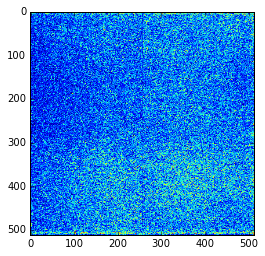

In [45]:
#test display image
fig2 = plt.figure()
plt.imshow(OBs[200])

## Add all counts of each image

In [46]:
nbr_obs = len(OBs)

In [47]:
w1 = widgets.IntProgress()
w1.max = nbr_data
display(w1)

sum_counts = []
for _index, _image in enumerate(OBs):
    _sum = np.sum(_image)
    sum_counts.append(_sum)
    w1.value = _index

In [48]:
# display to check values
trace1 = go.Scatter(
            x = np.arange(nbr_obs),
            y = sum_counts)
data = [trace1]

#layout = dict(title = 'Total Counts',
#        xaxis = dict(title = 'Image index'),
#        yaxis = dict(title = 'Counts')
#              )
# or
#
layout = go.Layout(
        title = "Total Counts",
        xaxis = {"title": 'Image index'},
        yaxis = {"title": "Counts"}
    )

figure = go.Figure(data = data, layout = layout)
iplot(figure)

# Convert 'Image Index' to 'time' 

In [49]:
import sys
sys.path.append('/users/j35/git/braggedge/python')

In [50]:
from neutronbraggedge.experiment_handler import *

In [51]:
import os
tof_spectra_file = os.path.join(root_dir, 'Image040_Spectra.txt')
_tof_handler = TOF(filename = tof_spectra_file)
print("TOF axis size: %d" %len(_tof_handler.tof_array))
print("Number of files: %d" %nbr_obs)

TOF axis size: 1490
Number of files: 1490


In [52]:
layout = go.Layout(title = "Sum Counts vs TOF")
layout.xaxis['title'] = "TOF (microS)"
layout.yaxis['title'] = "Counts"
trace1 = Scatter(x = _tof_handler.tof_array,
                y = sum_counts,
                mode = 'markers',
                marker = Marker( color = 'red',
                               symbol = 'square'))
data = Data([trace1])
fig = Figure(data=data, layout=layout)
iplot(fig)

# Retrieve Al Bragg edges values 

In [53]:
from neutronbraggedge.braggedge import BraggEdge

In [54]:
_handler = BraggEdge(material='Al', number_of_bragg_edges=4)

In [55]:
_Al_bragg_edges = _handler.bragg_edges
_Al_hkl = _handler.hkl

# Estimate best distance_source_detector 

In [56]:
detector_offset = 4.5e3 #micros   #default 4.5e3

In [76]:
distance_source_detector = 24.28  #m

# initialize tof -> lambda convertor
_exp = Experiment(tof = _tof_handler.tof_array,
                 distance_source_detector_m = distance_source_detector,
                 detector_offset_micros = detector_offset)

# retrieve lambda array
lambda_array_angstroms = _exp.lambda_array * 1e10

# format hkl labels
_hkl_string = []
for _hkl in _Al_hkl:
    _hkl_s = ",".join(str(x) for x in _hkl)
    _hkl_string.append(_hkl_s)

# plot
trace1 = go.Scatter(
            x = lambda_array_angstroms,
            y = sum_counts,
            mode = "markers")

layout = go.Layout(
            title = "Total Counts and Ideal Al Bragg Edge Values",
            xaxis = {"title": "Lambda (Angstroms)"},
            yaxis = {"title": "Counts"},
            annotations = []
    )

y_offset = 200
y_value = 8000000
max_x = 6

for _index, _value in enumerate(_Al_bragg_edges):
    if _value > max_x:
        continue
    bragg_line = {"type": "line",
                'x0': _value,
                'x1': _value,
                 'yref': "paper",
                 'y0': 0,
                 'y1': 1,
                 'line': {
                    'color': 'rgb(255, 0, 0)',
                    'width': 1
        }}
    layout.shapes.append(bragg_line)
    
    # add labels to plots
    _annot = dict(
                x=_value,
                y=1,
                text = _hkl_string[_index],
                yref="paper",
                font=dict(
                    family="Arial",
                    size=16,
                    color="rgb(150,50,50)"
                ),
                showarrow=True,
                arrowhead=3,
                ax=0,
                ay=-25)
                
    layout.annotations.append(_annot)
    
    

data = [trace1]
    
fig1 = go.Figure(data=data, layout=layout)
iplot(fig1)    

END OF CURRENT WORK